# Taller 4: Evaluar la relación entre la estructura de la red y dinámicas de difusión y propagación

## Parámetros del contagio

In [117]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from tqdm import tqdm
from collections import namedtuple
import os

# Cargar la red de superhéroes
with open('Red Marvel.pkl', 'rb') as file:
    G = pickle.load(file)
    
# Nodos infectados inicialmente
initial_zombies = [node for node in G.nodes() if G.nodes[node]['State'] == 'Z']
initial_zombies

['IRON MAN/TONY STARK',
 'HULK/DR. ROBERT BRUC',
 'SPIDER-MAN/PETER PAR',
 'WASP/JANET VAN DYNE',
 'SILVER SURFER/NORRIN',
 'HAWK',
 'SCARLET WITCH/WANDA',
 'CAPTAIN AMERICA',
 'WONDER MAN/SIMON WIL',
 'WOLVERINE/LOGAN',
 'VISION',
 'STORM/ORORO MUNROE S',
 'MR. FANTASTIC/REED R',
 'THING/BENJAMIN J. GR',
 'INVISIBLE WOMAN/SUE',
 'PUNISHER II/FRANK CA',
 'BEAST/HENRY &HANK& P',
 'CYCLOPS/SCOTT SUMMER',
 'THOR/DR. DONALD BLAK',
 'DR. STRANGE/STEPHEN',
 'PROFESSOR X/CHARLES',
 'WATSON-PARKER, MARY',
 'JAMESON, J. JONAH',
 'HUMAN TORCH/JOHNNY S',
 'HAVOK/ALEX SUMMERS',
 'COLOSSUS II/PETER RA',
 'JARVIS, EDWIN',
 'ANT-MAN/DR. HENRY J.',
 'DAREDEVIL/MATT MURDO',
 'FURY, COL. NICHOLAS']

In [101]:
# Definir la tabla de asortatividad
asortatividad_table = [
    [1, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 1, 1, 0, 0],
    [0, 1, 0, 0, 0, 1, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 0, 1, 0, 1, 0, 1]
]

# Obtener los tipos de sangre
tipos_sangre = ['O+', 'O-', 'A+', 'A-', 'B+', 'B-', 'AB+', 'AB-']

# Crear el diccionario de asortatividad 
E = {}
Muerde = namedtuple('Muerde', ['zombi', 'heroe'])
for i, receptor in enumerate(tipos_sangre):
    for j, donador in enumerate(tipos_sangre):
        E[Muerde(zombi=donador, heroe=receptor)] = asortatividad_table[i][j]

print("Si por ejemplo un zombi (Donador) con tipo de sangre B- muerde a un héroe (receptor) " \
    "con sangre B+, la asortatividad toma un valor de", E[Muerde(zombi="B-", heroe="B+")])

Si por ejemplo un zombi (Donador) con tipo de sangre B- muerde a un héroe (receptor) con sangre B+, la asortatividad toma un valor de 1


In [45]:
# Constante de asortatividad de la red
n = G.number_of_nodes()
m = G.number_of_edges()
A = lambda i,j: int(G.has_edge(i, j))
k = G.degree()
Q = (1 / m) * sum(A(i,j) - k[i] * k[j] / m for i in G.nodes() for j in G.nodes() if i != j) # -1.9965505995521529
print("El valor de Q es:", Q)

El valor de Q es: -1.9965505995521529


In [114]:
# Tabla para guardar valores ya calculados
I = pickle.load(open("I.pkl", "rb")) if os.path.exists("I.pkl") else {}

# Función de importancia entre nodos
def importancia(i,j):
    """
    Cálculo de la importancia del vecino-j para el nodo-i
    """
    # Memorizar
    if (i,j) in I:
        return I[(i,j)]
    
    E_ij = E[Muerde(zombi=G.nodes[i]["Type"], heroe=G.nodes[j]["Type"])]
    T = lambda i,j: G[i][j]["Weight"]
    vecinos = G.neighbors(i)
    result = (T(i,j) / sum(T(i,j) for j in vecinos)) + (E_ij * Q)

    I[(i,j)] = result
    return result


# Función de elección de a quién morder de forma aleatoria
def seleccionar_vecino(i):
    """
    Selecciona un vecino del nodo-i según su importancia
    """
    # Get the neighbors of node i
    neighbors = list(G.neighbors(i))
    
    # Calculate the importance for each neighbor
    importance_values = [importancia(i, j) for j in neighbors]
    
    # Correct for negative values
    lowest_value = min(importance_values)
    importance_values = [i - lowest_value for i in importance_values]
    
    # Normalize the importance values to sum to 1
    total_importance = sum(importance_values)
    normalized_importance = [
        value / total_importance 
        if total_importance != 0 
        else 1 / len(importance_values)
        for value in importance_values 
    ]
    
    # Choose a neighbor randomly based on the normalized importance values
    chosen_neighbor = random.choices(neighbors, weights=normalized_importance, k=1)[0]
    
    return chosen_neighbor

In [115]:
# Parámetros del modelo SI
days = 100
infection_probability = 0.5
recuperation_probability = 0.15

## Simulación (a)

100%|█████████████████████████████████████████| 100/100 [00:27<00:00,  3.69it/s]


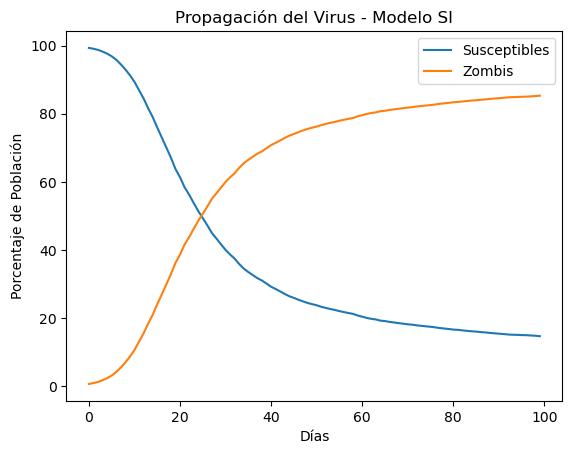

In [116]:
# Asegurarse de que los nodos semilla sean correctos
for node in G.nodes():
    G.nodes[node]['State'] = 'S'  # Susceptible
for node in initial_zombies:
    G.nodes[node]['State'] = 'Z'  # Zombi

# Simulación del modelo SI
susceptible_percentage = []
zombie_percentage = []

for day in tqdm(range(days)):
    new_zombies = set()
    for node in G.nodes():
        if G.nodes[node]['State'] == 'Z':
            if np.random.rand() <= infection_probability:
                neighbor = seleccionar_vecino(node)
                if G.nodes[neighbor]['State'] == 'S':
                    new_zombies.add(neighbor)
                    
    for new_zombie in new_zombies:
        G.nodes[new_zombie]['State'] = 'Z'

    susceptible_nodes = [node for node in G.nodes() if G.nodes[node]['State'] == 'S']
    zombie_nodes = [node for node in G.nodes() if G.nodes[node]['State'] == 'Z']

    susceptible_percentage.append(len(susceptible_nodes) / n * 100)
    zombie_percentage.append(len(zombie_nodes) / n * 100)

# Graficar resultados del modelo SI
plt.plot(range(days), susceptible_percentage, label='Susceptibles')
plt.plot(range(days), zombie_percentage, label='Zombis')
plt.xlabel('Días')
plt.ylabel('Porcentaje de Población')
plt.title('Propagación del Virus - Modelo SI')
plt.legend()
plt.show()

## Simulación (b)

100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.28it/s]


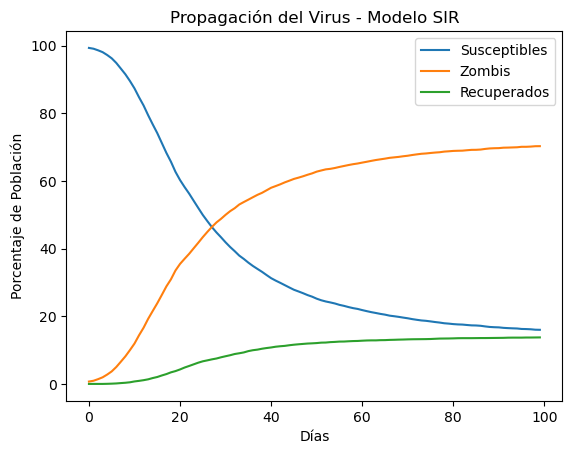

In [143]:
# Asegurarse de que los nodos semilla sean correctos
for node in G.nodes():
    G.nodes[node]['State'] = 'S'  # Susceptible
for node in initial_zombies:
    G.nodes[node]['State'] = 'Z'  # Zombi
    
# Incluir un nuevo atributo que indique la cantidad de días hasta la recuperación
for node in G.nodes():
    G.nodes[node]['DaysToRecover'] = 0  # Susceptible
for node in initial_zombies:
    G.nodes[node]['DaysToRecover'] = 5  # Zombi
    
# Simulación del modelo SIR
susceptible_percentage = []
zombie_percentage = []
recovered_percentage = []

for day in tqdm(range(days)):
    new_zombies = set()
    new_recovered = set()
    for node in G.nodes():
        if G.nodes[node]['State'] == 'Z':
            if np.random.rand() <= infection_probability:
                neighbor = seleccionar_vecino(node)
                if G.nodes[neighbor]['State'] == 'S':
                    new_zombies.add(neighbor)
                    
            G.nodes[node]['DaysToRecover'] -= 1 # Reducir en un día cuánto le falta para recuperarse
            # En caso de que ya hayan pasado 5 días, mirar la probabilidad
            # Solo hay una oportunidad de recuperarse
            if G.nodes[node]['DaysToRecover'] == 0:
                if np.random.rand() <= recuperation_probability:
                    new_recovered.add(node)

                    
    for new_zombie in new_zombies:
        G.nodes[new_zombie]['State'] = 'Z'
        G.nodes[new_zombie]['DaysToRecover'] = 5 # Le quedan 5 días hasta que pueda recuperarse
        
    for node in new_recovered:
        G.nodes[node]['State'] = 'R'

    susceptible_nodes = [node for node in G.nodes() if G.nodes[node]['State'] == 'S']
    zombie_nodes = [node for node in G.nodes() if G.nodes[node]['State'] == 'Z']
    recovered_nodes = [node for node in G.nodes() if G.nodes[node]['State'] == 'R']

    susceptible_percentage.append(len(susceptible_nodes) / n * 100)
    zombie_percentage.append(len(zombie_nodes) / n * 100)
    recovered_percentage.append(len(recovered_nodes) / n * 100)

# Graficar resultados del modelo SIR
plt.plot(range(days), susceptible_percentage, label='Susceptibles')
plt.plot(range(days), zombie_percentage, label='Zombis')
plt.plot(range(days), recovered_percentage, label='Recuperados')
plt.xlabel('Días')
plt.ylabel('Porcentaje de Población')
plt.title('Propagación del Virus - Modelo SIR')
plt.legend()
plt.show()

In [144]:
susceptible_percentage[-1], zombie_percentage[-1], recovered_percentage[-1]

(15.992503513977823, 70.2639387786975, 13.74355770732469)

## Estrategia 1 (c)

In [67]:
# Calculate vote-rank for each node
voterank_values = nx.algorithms.centrality.voterank(G, number_of_nodes=80)

# Filter nodes that are not in state 'Z'
eligible_nodes = [node for node in voterank_values if G.nodes[node]['State'] != 'Z']

# Select the first 50 eligible nodes, or the most available
nodes_voterank = eligible_nodes[:min(50, len(eligible_nodes))]
nodes_voterank

['ANGEL/WARREN KENNETH',
 'SHE-HULK/JENNIFER WA',
 'MARVEL GIRL/JEAN GRE',
 'SUB-MARINER/NAMOR MA',
 'HERCULES [GREEK GOD]',
 'ICEMAN/ROBERT BOBBY',
 'BLACK WIDOW/NATASHA',
 'NIGHTCRAWLER/KURT WA',
 'QUICKSILVER/PIETRO M',
 'ROGUE /',
 'ROBERTSON, JOE',
 'CANNONBALL II/SAM GU',
 'SHADOWCAT/KATHERINE',
 'NOVA/RICHARD RIDER',
 'QUASAR III/WENDELL V',
 'PSYLOCKE/ELISABETH B',
 "BLACK PANTHER/T'CHAL",
 'CRYSTAL [INHUMAN]',
 'SUMMERS, NATHAN CHRI',
 'BLACK KNIGHT V/DANE',
 'FIRESTAR/ANGELICA JO',
 'PARKER, MAY',
 'GAMBIT/REMY LEBEAU',
 'DR. DOOM/VICTOR VON',
 'CAGE, LUKE/CARL LUCA',
 'SUNSPOT/ROBERTO DACO',
 'USAGENT/CAPTAIN JOHN',
 'NAMORITA/NITA PRENTI',
 'RICHARDS, FRANKLIN B',
 'BANSHEE/SEAN CASSIDY',
 'IRON FIST/DANIEL RAN',
 'LEEDS, BETTY BRANT',
 'KINGPIN/WILSON FISK',
 'THUNDERBIRD II/JAMES',
 'URICH, BEN',
 'JONES, RICHARD MILHO',
 'COOPER, DR. VALERIE',
 'NELSON, FRANKLIN FOG',
 'BOOMER/TABITHA SMITH',
 'SERSI/SYLVIA',
 'DUGAN, TIMOTHY ALOYI',
 'IRON MAN IV/JAMES R.',
 'JUBILEE/JU

## Estrategia 2 (d)

In [78]:
# Calculate closeness centrality for each node
closeness_values = nx.algorithms.centrality.closeness_centrality(G)

# Order nodes by closeness centrality in descending order
sorted_nodes = sorted(closeness_values, key=closeness_values.get, reverse=True)

# Filter nodes that are not in state 'Z'
eligible_nodes = [node for node in sorted_nodes if G.nodes[node]['State'] != 'Z']

# Select the first 'num_nodes' eligible nodes
nodes_closeness_centrality = eligible_nodes[:min(50, len(eligible_nodes))]
nodes_closeness_centrality

['SHE-HULK/JENNIFER WA',
 'ANGEL/WARREN KENNETH',
 'SUB-MARINER/NAMOR MA',
 'PROFESSOR X/CHARLES',
 'HERCULES [GREEK GOD]',
 'ICEMAN/ROBERT BOBBY',
 'MARVEL GIRL/JEAN GRE',
 'BLACK WIDOW/NATASHA',
 'NIGHTCRAWLER/KURT WA',
 'QUICKSILVER/PIETRO M',
 'ROGUE /',
 "BLACK PANTHER/T'CHAL",
 'BLACK KNIGHT V/DANE',
 'NOVA/RICHARD RIDER',
 'QUASAR III/WENDELL V',
 'SHADOWCAT/KATHERINE',
 'CRYSTAL [INHUMAN]',
 'CAGE, LUKE/CARL LUCA',
 'PSYLOCKE/ELISABETH B',
 'RICHARDS, FRANKLIN B',
 'DR. DOOM/VICTOR VON',
 'GAMBIT/REMY LEBEAU',
 'FIRESTAR/ANGELICA JO',
 'IRON FIST/DANIEL RAN',
 'CANNONBALL II/SAM GU',
 'NAMORITA/NITA PRENTI',
 'BINARY/CAROL DANVERS',
 'ROBERTSON, JOE',
 'CAPTAIN MARVEL II/MO',
 'USAGENT/CAPTAIN JOHN',
 'POLARIS/LORNA DANE',
 'JONES, RICHARD MILHO',
 'SUMMERS, NATHAN CHRI',
 'TIGRA/GREER NELSON',
 'SERSI/SYLVIA',
 'COOPER, DR. VALERIE',
 'DUGAN, TIMOTHY ALOYI',
 'JUSTICE II/VANCE AST',
 'NELSON, FRANKLIN FOG',
 'SUNSPOT/ROBERTO DACO',
 'BANSHEE/SEAN CASSIDY',
 'WONG',
 'IRON MAN 

## Simulación (e)

In [73]:
def simulate_SIR(seed):
    # Asegurarse de que los nodos semilla sean correctos
    for node in G.nodes():
        G.nodes[node]['State'] = 'S'  # Susceptible
    for node in initial_zombies:
        G.nodes[node]['State'] = 'Z'  # Zombi
    # Incluir los vacunados
    for node in seed:
        G.nodes[node]['State'] = 'V'  # Vacunado

    # Incluir un nuevo atributo que indique la cantidad de días hasta la recuperación
    for node in G.nodes():
        G.nodes[node]['DaysToRecover'] = 0  # Susceptible
    for node in initial_zombies:
        G.nodes[node]['DaysToRecover'] = 5  # Zombi

    # Simulación del modelo SIR
    susceptible_percentage = []
    zombie_percentage = []
    recovered_percentage = []

    for day in tqdm(range(days)):
        new_zombies = set()
        new_recovered = set()
        for node in G.nodes():
            if G.nodes[node]['State'] == 'Z':
                if np.random.rand() <= infection_probability:
                    neighbor = seleccionar_vecino(node)
                    if G.nodes[neighbor]['State'] == 'S':
                        new_zombies.add(neighbor)

                G.nodes[node]['DaysToRecover'] -= 1 # Reducir en un día cuánto le falta para recuperarse
                # En caso de que ya hayan pasado 5 días, mirar la probabilidad
                # Solo hay una oportunidad de recuperarse
                if G.nodes[node]['DaysToRecover'] == 0:
                    if np.random.rand() <= recuperation_probability:
                        new_recovered.add(node)


        for new_zombie in new_zombies:
            G.nodes[new_zombie]['State'] = 'Z'
            G.nodes[new_zombie]['DaysToRecover'] = 5 # Le quedan 5 días hasta que pueda recuperarse

        for node in new_recovered:
            G.nodes[node]['State'] = 'R'

        susceptible_nodes = [node for node in G.nodes() if G.nodes[node]['State'] == 'S']
        zombie_nodes = [node for node in G.nodes() if G.nodes[node]['State'] == 'Z']
        recovered_nodes = [node for node in G.nodes() if G.nodes[node]['State'] == 'R']

        susceptible_percentage.append(len(susceptible_nodes) / n * 100)
        zombie_percentage.append(len(zombie_nodes) / n * 100)
        recovered_percentage.append(len(recovered_nodes) / n * 100)
        
    return susceptible_percentage, zombie_percentage, recovered_percentage

100%|█████████████████████████████████████████| 100/100 [00:27<00:00,  3.68it/s]


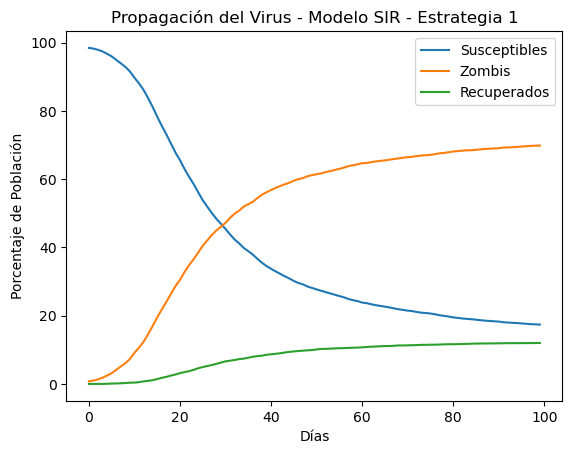

In [139]:
# Simular Estrategia 1
susceptible_percentage, zombie_percentage, recovered_percentage = simulate_SIR(nodes_voterank)

# Graficar resultados del modelo SIR
plt.plot(range(days), susceptible_percentage, label='Susceptibles')
plt.plot(range(days), zombie_percentage, label='Zombis')
plt.plot(range(days), recovered_percentage, label='Recuperados')
plt.xlabel('Días')
plt.ylabel('Porcentaje de Población')
plt.title('Propagación del Virus - Modelo SIR - Estrategia 1')
plt.legend()
plt.show()

In [140]:
susceptible_percentage[-1], zombie_percentage[-1], recovered_percentage[-1]

(17.38247696392316, 69.84226143995002, 11.994377635483367)

100%|█████████████████████████████████████████| 100/100 [00:27<00:00,  3.61it/s]


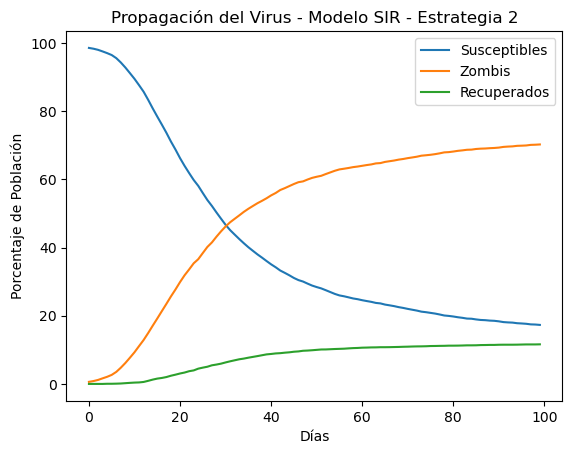

In [141]:
# Simular Estrategia 2
susceptible_percentage, zombie_percentage, recovered_percentage = simulate_SIR(nodes_closeness_centrality)

# Graficar resultados del modelo SIR
plt.plot(range(days), susceptible_percentage, label='Susceptibles')
plt.plot(range(days), zombie_percentage, label='Zombis')
plt.plot(range(days), recovered_percentage, label='Recuperados')
plt.xlabel('Días')
plt.ylabel('Porcentaje de Población')
plt.title('Propagación del Virus - Modelo SIR - Estrategia 2')
plt.legend()
plt.show()

In [142]:
susceptible_percentage[-1], zombie_percentage[-1], recovered_percentage[-1]

(17.320006247071685, 70.27955645791036, 11.619553334374512)